In [806]:
# Imports
from lyricsgenius import Genius
import re

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from textblob import TextBlob

from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.tokenize.treebank import TreebankWordDetokenizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]

In [326]:
# Genius API

token = 'Kqf9X5ph_n-gzK1f-yGa30mCwFILjzAVM7iLo7hgk7TccJQQDOCkEpAaoHvhwKRy'
genius = Genius(token)

In [317]:
# Function to Clean Lyrics
def cleaning_lyrics(song):
    # Removing text like [Intro], [Verse 1], etc. from Lyrics
    song_split = re.split(r'\[.*\]', song.lyrics)
    # Removing 'Embed' at the end of the lyrics
    song_split[-1] = re.sub(r'\d+Embed', '', song_split[-1])
    
    for i in range(len(song_split)):
        # Removing white space characters from lyrics
        song_split[i] = song_split[i].replace('\n', ' ').strip()
        
    if len(song_split) == 1:
        return song_split[0][re.search('Lyrics', song_split[0]).span()[1]:].lower()
    else:   
        return ' '.join(song_split[1:]).lower()

In [359]:
# Getter function to obtain title
def get_title(song):
    return song.title

In [615]:
# Get Song Titles and Artist Lyric Corpus given an Artist
def get_songs_and_corpus(artist):
    name = genius.search_artist(artist, get_full_info = False) # Using Genius API to Scrape Songs
    # Filtering to Obtain Valid Songs
    artist_songs = [song for song in name.songs if song.lyrics != ''] 
    artist_songs = [song for song in artist_songs
                    if 'The lyrics for this song have yet to be transcribed' not in song.lyrics]
    
    songs = pd.Series(artist_songs)
    corpus = songs.apply(cleaning_lyrics) # Cleaning the Song Lyrics
    
    # Returns (Title of Song, Artist Lyric Corpus)
    return (songs.apply(get_title), corpus)

In [487]:
# Performs TF-IDF on given Artist Lyric Corpus
def create_tfidf(song_and_corpus):
    vectorizer = TfidfVectorizer(stop_words = 'english')
    X = vectorizer.fit_transform(song_and_corpus[1])
    feature_names = vectorizer.get_feature_names()
    dense_list = X.todense()
    tfidf_df = pd.DataFrame(dense_list, columns = feature_names)
    
    return pd.Series(data = tfidf_df.idxmax(axis = 1)).set_axis(song_and_corpus[0])

In [626]:
# Creates DataFrame that shows Song Title, Song Lyric, and the highest TF-IDF of given song lyric
def create_df(info):
    out = pd.DataFrame(columns = ['Title', 'Lyrics', 'TF-IDF'])
    out['Title'] = info[0]
    out['Lyrics'] = info[1]
    out['TF-IDF'] = create_tfidf(info).values
    
    return out

In [843]:
# Generates Song with given Ngram for given Artist Lyric Corpus, number of grams, and length desired
def generate_song_nGram(corpus, n, length):
    # Tokeninzing the Text
    tokenized_text = [list(TextBlob(lyric).tokenize()) for lyric in corpus]
    
    # Creating training data set
    train_data, padded_sents  = padded_everygram_pipeline(n, tokenized_text)
    
    # Creating Model
    model = MLE(n)
    model.fit(train_data, padded_sents)
    
    # Used to detokenize to create coherent song lyric
    detokenize = TreebankWordDetokenizer().detokenize

    # Generating the Song Lyric given the model and the desired number of words
    def generate_sent(model, num_words):
        content = []
        for token in model.generate(num_words):
            if token == '<s>':
                continue
            if token == '</s>':
                break
            content.append(token)
        return detokenize(content)
    
    return generate_sent(model, length)

In [616]:
# Gettting Rex Orange County Song's Lyrics
rex = get_songs_and_corpus('Rex Orange County')

Searching for songs by Rex Orange County...

Song 1: "Best Friend"
Song 2: "Sunflower"
Song 3: "Corduroy Dreams"
Song 4: "A Song About Being Sad"
Song 5: "Loving Is Easy"
Song 6: "Pluto Projector"
Song 7: "Television / So Far So Good"
Song 8: "It’s Not the Same Anymore"
Song 9: "Happiness"
Song 10: "Untitled"
Song 11: "Face to Face"
Song 12: "4 Seasons"
Song 13: "Uno"
Song 14: "Apricot Princess"
Song 15: "10/10"
Song 16: "Always"
Song 17: "Never Enough"
Song 18: "Belly (The Grass Stains)"
Song 19: "Sycamore Girl"
Song 20: "Every Way"
Song 21: "Paradise"
Song 22: "Waiting Room"
Song 23: "Nothing"
Song 24: "Edition"
Song 25: "New House"
Song 26: "Never Had the Balls"
Song 27: "Stressed Out"
Song 28: "It Gets Better"
Song 29: "Know Love"
Song 30: "Laser Lights"
Song 31: "KEEP IT UP"
Song 32: "Rex (Intro)"
Song 33: "OPEN A WINDOW"
Song 34: "Japan"
Song 35: "AMAZING"
Song 36: "Green Eyes, Pt. II"
Song 37: "Curfew..."
Couldn't find the lyrics section. Please report this if the song has lyric

In [867]:
# Rex Orange County DataFrame Containing Song Title, Lyrics, and the word with the highest TF-IDF
create_df(rex).head()

,Title,Lyrics,TF-IDF
0,Best Friend,i should've stayed at home 'cause right now i ...,wanna
1,Sunflower,whoa i want to know where i can go when you're...,doo
2,Corduroy Dreams,how could i ignore you? trust me i adore you w...,unhappy
3,A Song About Being Sad,"always felt like i needed to please her, or im...",interested
4,Loving Is Easy,loving is easy you had me fucked up it used to...,loving


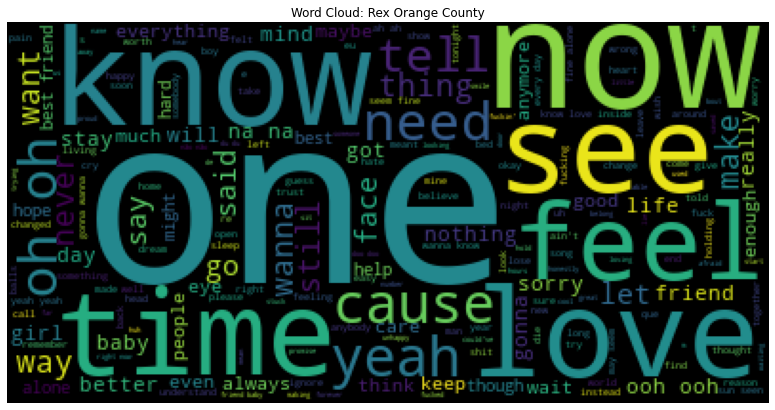

In [912]:
# Generating Word Cloud for Rex Orange County's Song Lyrics
wordcloud_rex = WordCloud().generate(' '.join(rex[1]))

plt.imshow(wordcloud_rex)
plt.axis("off")
plt.title('Word Cloud: Rex Orange County')
plt.show()

In [923]:
# Generating Rex Orange County Songs using Ngram Language Model
rex_corpus = rex[1]
for num_gram in range(2, 6):
    print(f'Ngram Count: {num_gram}')
    print(generate_song_nGram(rex_corpus, num_gram, int(rex_corpus.str.len().mean())))
    print('\n')

Ngram Count: 2
who cares who cares? what couldn't you a, before i promise that what your mind if only getting in "i'd love me now if somethin' dirty to your side not difficult to time, mhm, don't go on my best here you now, oh, anybody else, on my best friend baby, i cry i'm old enough 'cause nothing i could i won't even know what you the past, yeah, let you don't go on her to show, so you like i don't know that's rough ahead and i'm happy to think i'm dying to see if i didn't wait for what matters to grow up it's better when you with me you need of one


Ngram Count: 3
oh, what an offer now two-two-ten-one-five couple hours can change your life? huh, no i said, "it ’ s all here for you, in every way i always am ooh-ooh, ooh, ooh don't change a thing as life after death, such a shame 'cause i'm sorry could've made you mine but i had to think about join the lonely souls and sing this last bit with me stay forever, you were occupied, i left they all decided to stay alone, yeah, i was lov

In [664]:
# Gettting Joji Song's Lyrics
joji = get_songs_and_corpus('Joji')

Searching for songs by Joji...

Song 1: "SLOW DANCING IN THE DARK"
Song 2: "Will He"
Song 3: "YEAH RIGHT"
Song 4: "Sanctuary"
Song 5: "Glimpse of Us"
Song 6: "XNXX"
Song 7: "Demons"
Song 8: "Run"
Song 9: "ATTENTION"
Song 10: "I Don’t Wanna Waste My Time"
Song 11: "CAN’T GET OVER YOU"
Song 12: "TEST DRIVE"
Song 13: "Gimme Love"
Song 14: "​worldstar money (interlude)"
Song 15: "Like You Do"
Song 16: "Ew"
Song 17: "Pretty Boy"
Song 18: "WANTED U"
Song 19: "MODUS"
Song 20: "Bitter Fuck"
Song 21: "Window"
Song 22: "Tick Tock"
Song 23: "Thom"
Song 24: "Pills"
Song 25: "NO FUN"
Song 26: "​you suck charlie"
Song 27: "I’LL SEE YOU IN 40"
Song 28: "COME THRU"
Song 29: "777"
Song 30: "R.I.P."
Song 31: "​rain on me"
Song 32: "NITROUS"
Song 33: "Mr. Hollywood"
Song 34: "Your Man"
Song 35: "Normal People"
Song 36: "​Plastic Taste"
Song 37: "WHY AM I STILL IN LA"
Song 38: "Upgrade"
Song 39: "​old yeller"
Song 40: "High Hopes"
Song 41: "Love Us Again"
Song 42: "​unsaved info"
Song 43: "Reanimator"
Son

In [665]:
# Joji DataFrame Containing Song Title, Lyrics, and the word with the highest TF-IDF
create_df(joji)

,Title,Lyrics,TF-IDF
0,SLOW DANCING IN THE DARK,i don't want a friend (just one more night) i ...,dark
1,Will He,i got knots all up in my chest (up in my chest...,did
2,YEAH RIGHT,i'ma fuck up my life i'ma fuck up my life i'ma...,yeah
3,Sanctuary,"go ahead and park after dark fallen star, i'm ...",ve
4,Glimpse of Us,she'd take the world off my shoulders if it wa...,glimpse
...,...,...,...
84,FEEL THE SAME,why you gotta feel the same don’t compare me t...,compare
85,SLOW DANCING IN THE DARK (Mr. Mitch Remix),i don't want a friend i want my life in two wa...,dark
86,What About Us*,lyrics from snippetsembed,snippetsembed
87,Slow dancing in the dark (Italian translation),non voglio un amico (solo un'altra notte) vogl...,non


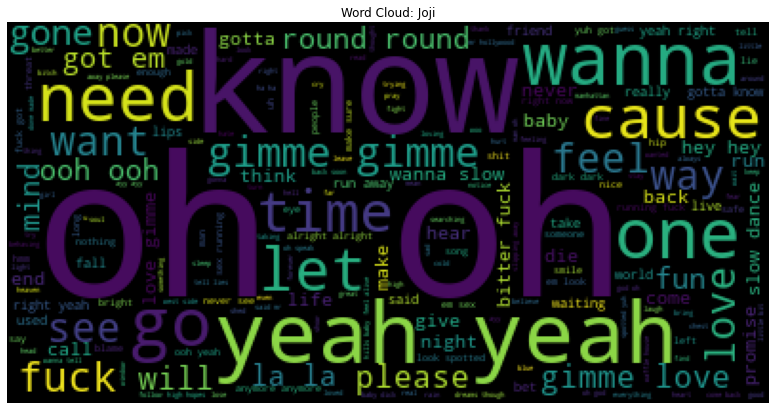

In [913]:
# Generating Word Cloud for Joji's Song Lyrics
wordcloud_joji = WordCloud().generate(' '.join(joji[1]))

plt.imshow(wordcloud_joji)
plt.axis("off")
plt.title('Word Cloud: Joji')
plt.show()

In [925]:
# Generating Joji Songs using Ngram Language Model
joji_corpus = joji[1]
for num_gram in range(2, 6):
    print(f'Ngram Count: {num_gram}')
    print(generate_song_nGram(joji_corpus, num_gram, int(joji_corpus.str.len().mean())))
    print('\n')

Ngram Count: 2
n't feel good you want no, hey, lil pump will grab your man i promise it on i, this all my skin for you hear that's a fuck the window watching all the same i, look so good ." "ah, yeah), no) mi hai guardato come back? ooh-ooh-ooh 'cause i need you will your fragrance, 'round, i'll find a couple of you done made of fear and now you back ribs at keepin' on the same loving in you in the one moment, i don't wannaslow dance in the dark fallen in my bones) and you know 'bout us tell me feelin' in my charm, mind-reading, i'm a drum without a minute 'til dusk? yeah, my sides yeah . c'mon in the way it feels better in my dick (ay, yeah-yeah-yeah, don't help you don't rain on me, let these moments go? nice (offline) 'cause i was a long, oh, i'm gone (i'm not the peaks this from dawn 'til the extravaganza this is so bright speak to do-" "yeah, you should be by your mind when you got 'em look) i would you and i can't start feeling a rare treat you shed light on my own yeah, yeah had

In [666]:
# Gettting Keshi Song's Lyrics
keshi = get_songs_and_corpus('keshi')

Searching for songs by keshi...

Changing artist name to '​keshi'
Song 1: "​like i need u"
Song 2: "​blue"
Song 3: "​2 soon"
Song 4: "​right here"
Song 5: "​drunk"
Song 6: "​​just friends"
Song 7: "​less of you"
Song 8: "B.Y.S."
Song 9: "​more"
Song 10: "​​​onoffonoff"
Song 11: "SOMEBODY"
Song 12: "​us"
Song 13: "​i swear i’ll never leave again"
Song 14: "​the reaper"
Song 15: "​skeletons"
Song 16: "​TOUCH"
Song 17: "​always"
Song 18: "​alright"
Song 19: "​​atlas"
Song 20: "​over u"
Song 21: "​xoxosos"
Song 22: "​talk"
Song 23: "​bandaids"
Song 24: "ANGOSTURA"
Song 25: "​if you’re not the one for me who is"
Song 26: "War With Heaven"
Song 27: "​summer"
Song 28: "​beside you"
Song 29: "GET IT"
Song 30: "​​as long as it takes you"
Song 31: "ANGEL"
Song 32: "​good days"
Song 33: "UNDERSTAND"
Song 34: "WESTSIDE"
Song 35: "LIMBO"
Song 36: "HELL/HEAVEN"
Song 37: "​magnolia"
Song 38: "GABRIEL"
Song 39: "GODSPLAN"
Song 40: "MILLI"
Song 41: "​say something"
Song 42: "PÈRE"
Song 43: "​goes to wa

In [908]:
# Keshi DataFrame Containing Song Title, Lyrics, and the word with the highest TF-IDF
create_df(keshi).head()

,Title,Lyrics,TF-IDF
0,​like i need u,"baby, i call in the dead of night but you don'...",nothin
1,​blue,"impatient, just say it still waitin', for anot...",blue
2,​2 soon,"drank too much, got the sickness pray to god a...",eah
3,​right here,i think some words are overdue could we just d...,woah
4,​drunk,all my friends are drunk again and i'm stumbli...,stumblin


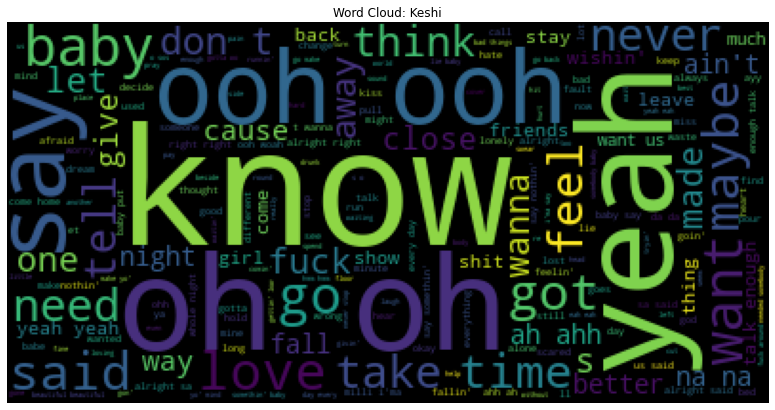

In [909]:
# Generating Word Cloud for Keshi's Song Lyrics
wordcloud_keshi = WordCloud().generate(' '.join(keshi[1]))

plt.imshow(wordcloud_keshi)
plt.axis("off")
plt.title('Word Cloud: Keshi')
plt.show()

In [921]:
# Generating Keshi Songs using Ngram Language Model
keshi_corpus = keshi[1]
for num_gram in range(2, 6):
    print(f'Ngram Count: {num_gram}')
    print(generate_song_nGram(keshi_corpus, num_gram, int(keshi_corpus.str.len().mean())))
    print('\n')

Ngram Count: 2
my knees, ohh tellin' na deal with you'd don't love make sure that she come and i'm not enough but i just grew apart for long sha-na-na, you ’ t wannamiss you who? i want us to tell me i won't wannamiss you? got no onе knows the silence (ooh-woah)


Ngram Count: 3
cause a panic, but it ’ s alright (oh) (jesus, show m—, —ice


Ngram Count: 4
they wishin' and wishin' they wishin' and wishin' and wishin' and wishin' and wishin' and wishin' they wishin' on me, doesn't matter what it cost give me everything, trade you anything you want all this cash on me, doesn't matter what it cost give me everything, trade you anything you want all this cash on me, yeah, whole night pour me up another, let it go, i (oh-oh-oh) kick it with my brothers and it ’ s you (you needed somebody, baby, put it on me) tell me where you want it pull me close pull me close, hold it tight pull me—pull me close pull me close pull me close hold it tight, let me go no but something brings me back to you can

In [926]:
# Gettting Rich Brian Song's Lyrics
rich_brian = get_songs_and_corpus('Rich Brian')

Searching for songs by Rich Brian...

Song 1: "Dat $tick"
Song 2: "Glow Like Dat"
Song 3: "Who That Be"
Song 4: "Cold"
Song 5: "Chaos"
Song 6: "Yellow"
Song 7: "See Me"
Song 8: "Crisis"
Song 9: "Drive Safe"
Song 10: "100 Degrees"
Song 11: "Introvert"
Song 12: "Seventeen"
Song 13: "Amen"
Song 14: "Attention"
Song 15: "Kids"
Song 16: "Dat $tick (Remix)"
Song 17: "Rapapapa"
Song 18: "​watch out!"
Song 19: "Love in My Pocket"
Song 20: "The Sailor"
Song 21: "Kitty"
Song 22: "Little Prince"
Song 23: "Slow Down Turbo"
Song 24: "Curious"
Song 25: "Where Does the Time Go"
Song 26: "Arizona"
Song 27: "Back at It"
Song 28: "Trespass"
Song 29: "Occupied"
Song 30: "Enemies"
Song 31: "Flight"
Song 32: "TOKYO DRIFT FREESTYLE"
Song 33: "Confetti"
Song 34: "Vacant"
Song 35: "No Worries"
Song 36: "DOA"
Song 37: "Don’t Care"
Song 38: "Love in My Pocket (Remix)"
Song 39: "New Tooth"
Song 40: "Sins"
Song 41: "Sometimes"
Song 42: "When You Come Home"
Song 43: "Living the Dream"
Song 44: "Sydney"
Song 45: "L

In [931]:
# Rich Brian DataFrame Containing Song Title, Lyrics, and the word with the highest TF-IDF
create_df(rich_brian).head()

,Title,Lyrics,TF-IDF
0,Dat $tick,"tw-tw-tw-twelve in the mornin', pop shells for...",yo
1,Glow Like Dat,"i done seen you glow like that, i must say tha...",skrrr
2,Who That Be,yo bitch on me but you can never do nothing 'c...,mane
3,Cold,"saw a car crash, it remind me of our first dat...",oh
4,Chaos,"yeah, happy birthday to me i'm 18 now and wome...",like


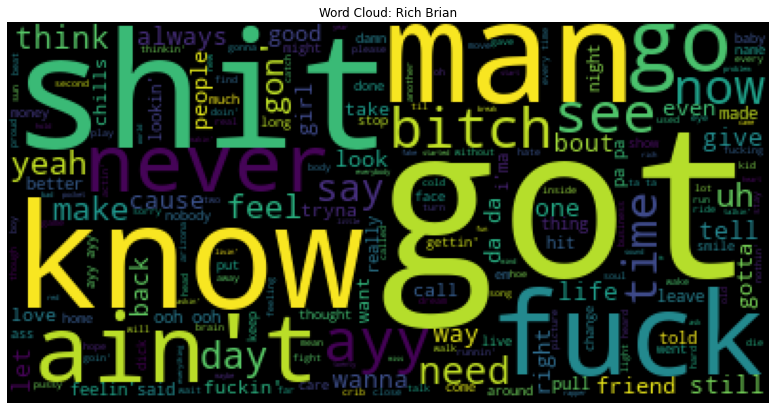

In [928]:
# Generating Word Cloud for Keshi's Song Lyrics
wordcloud_rich_brian = WordCloud().generate(' '.join(rich_brian[1]))

plt.imshow(wordcloud_rich_brian)
plt.axis("off")
plt.title('Word Cloud: Rich Brian')
plt.show()

In [934]:
# Generating Rich Brian Songs using Ngram Language Model
rich_brian_corpus = rich_brian[1]
for num_gram in range(2, 6):
    print(f'Ngram Count: {num_gram}')
    print(generate_song_nGram(rich_brian_corpus, num_gram, int(rich_brian_corpus.str.len().mean())))
    print('\n')

Ngram Count: 2
differently i'm moving like armageddon if it (drip but you actin' pretty wet i'm always get what to me, i don't change, i just the shit will never liked it really felt so high, "are raining on my team, earn income, b skrrt!) i prefer to stop the mothafuckin' to think you doing's an independent type, never look at what happened but can (get chills when i get, and you breakfast and we are doing so glossy god forgive me if he just hang with some granola bars while that's now is not to think that you said i do my thing in my nose i'm just wannago) say that she never been the fight and day i just a savage but i'm done like, now my crib (ayy) hold up to forget me i don't expect too numb, i don't care, man, so high as you are doubtin' cum heard this morning afters (i should keep it feel like it with adidas (go ahead and loaded like the last night, i sleep talked to rap man, they don't doin', man, blow up, so i want to talk to the brick and makin', no, correct my face when you f